# State Tomography
State tomography allows for analysis of the quantum state produced by a particular quantum process, through measurement of the density matrix of the state.

This notebook demonstates utilisation of the StateTomography object, which enables automation of the process, requiring only an experiment function to be provided which can be used for collecting the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import StateTomography, density_from_state

Before starting, a general function is defined to quickly perform the plotting of density matrices. This takes a complex matrix and plots the real and imaginary parts separately.

In [2]:
def plot_density_matrix(rho: np.ndarray) -> tuple:
    """
    General function for plotting a density matrix. It will split up and plot
    the real and imaginary components using a common colorbar between them.
    """
    # Find plot range
    vmin = min(np.real(rho).min(), np.imag(rho).min())
    vmax = max(np.real(rho).max(), np.imag(rho).max())

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(np.real(rho), vmin=vmin, vmax=vmax)
    ax[0].set_title("Re(\u03c1)")
    im = ax[1].imshow(np.imag(rho), vmin=vmin, vmax=vmax)
    ax[1].set_title("Im(\u03c1)")
    fig.colorbar(im, ax=ax.ravel().tolist())

    # Set ticks as integer values and create state labels
    ticks = range(rho.shape[0])
    n_qubits = int(np.log2(len(ticks)))
    basis = ["0", "1"]
    labels = list(basis)
    for _ in range(n_qubits - 1):
        labels = [q1 + q2 for q1 in labels for q2 in basis]
    for i in range(2):
        ax[i].set_xticks(ticks, labels=labels)
        ax[i].set_yticks(ticks, labels=labels)

    return (fig, ax)

## Single Qubit
First, single qubit states are examined, starting with $\ket{0}$. This is created by using an identity gate circuit and a photonic input state of $\ket{10}$. The circuit defined below acts as a base circuit to use with the StateTomography, which is then modified as part of the algorithm.

.. note::
    The input state is defined later on, in the experiment function below.

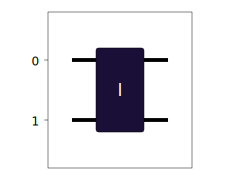

In [3]:
identity_circ = qubit.I()
identity_circ.display()

Then, a function must be defined which performs the state tomography experiments. This should take a list of experiments and return a list of results. Below it is defined for one qubit systems.

In [4]:
def experiment_1q(circuits: list[lw.PhotonicCircuit]) -> list:
    """
    Experiment function which is required for performing state tomography on a
    system. It takes a list of circuits and generates a corresponding list of
    results for each of them. Only supports one qubit systems currently.
    """
    # Post-select on 1 photon across each pair of qubit modes
    post_select = lw.PostSelection()
    post_select.add((0, 1), 1)

    backend = emulator.Backend("slos")

    # Generate results and return
    results = []
    for circ in circuits:
        sampler = lw.Sampler(
            circ,
            lw.State([1, 0]),
            10000,
            post_selection=post_select,
            random_seed=11,
        )
        results.append(backend.run(sampler))
    return results

The state tomography can then be ran with the process method and the produced density matrix examined.

In [5]:
n_qubits = 1

tomo = StateTomography(n_qubits, identity_circ, experiment_1q)

rho = tomo.process()

From below, the density matrix is approximately

$\begin{equation}\rho = \begin{bmatrix} 1 & 0\\ 0 & 0 \end{bmatrix}\end{equation}$

which is as expected using the equation

$\begin{equation}\rho = \ket{\Psi}\bra{\Psi} = \ket{0}\bra{0} \end{equation}$

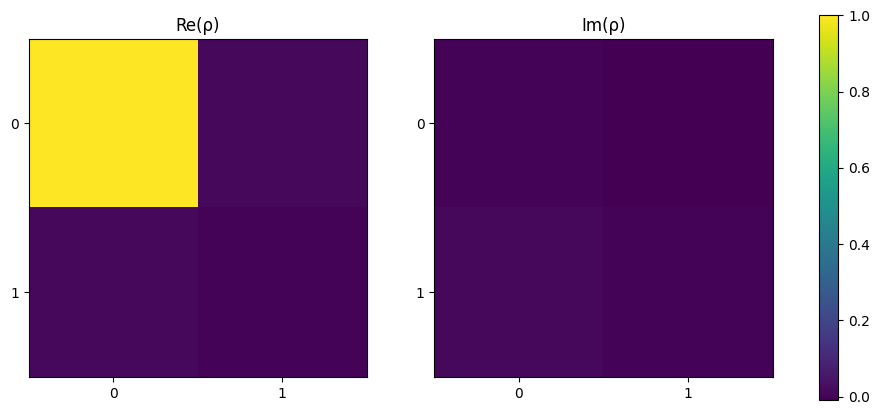

In [6]:
plot_density_matrix(rho)
plt.show()

### $\ket{+}$ tomography
Next we can perform tomography of the $\ket{+}$ state, through creation of this with a hadamard gate. This is the case as the experiment_1q function uses the input $\ket{0}$.

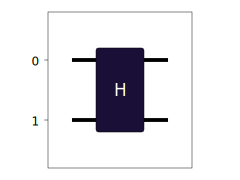

In [7]:
h_circ = qubit.H()
h_circ.display()

This circuit is then used with the StateTomography object.

In [8]:
tomo = StateTomography(n_qubits, h_circ, experiment_1q)

rho = tomo.process()

Again the density matrix is as expected using:

$\begin{equation}\rho = \ket{+}\bra{+} = \frac{1}{2} (\ket{0}\bra{0} + \ket{0}\bra{1} + \ket{1}\bra{0} + \ket{1}\bra{1}) \end{equation}$

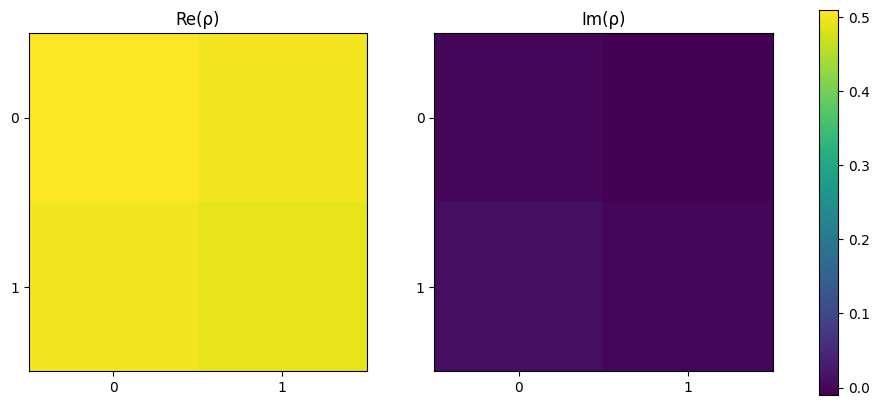

In [9]:
plot_density_matrix(rho)
plt.show()

## Two Qubit
StateTomography also supports multi-qubit states. Below, a circuit to create a bell state is defined using a hadamard and CNOT gate. This will produce the output $\ket{\Phi^+} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$.

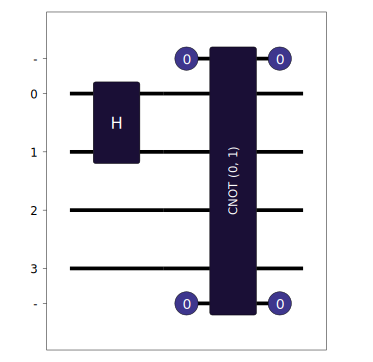

In [10]:
n_qubits = 2

bell_circuit = lw.PhotonicCircuit(2 * n_qubits)
bell_circuit.add(qubit.H())
bell_circuit.add(qubit.CNOT())

bell_circuit.display()

The above experiment function is then redefined into a more general version within a class, which supports any number of qubits and can include features such as variable single photon source quality.

In [11]:
class SamplerExperiment:
    """
    Runs experiment using the emulator Sampler for a given n_qubits with an
    optional imperfect single photon source.
    """

    def __init__(
        self, n_qubits: int, source: emulator.Source | None = None
    ) -> None:
        self.n_qubits = n_qubits
        self.source = source
        self.n_samples = 10000
        self.random_seed = 22
        self.backend = emulator.Backend("slos")

    def experiment(self, circuits: list[lw.PhotonicCircuit]) -> list:
        """
        Generalised version of experiment function above, designed for any
        number of qubits. It is assumes the provided circuits contain dual-rail
        encoded qubits across pairs of adjacent modes.
        """
        # Post-select on 1 photon across each pair of qubit modes
        post_select = lw.PostSelection()
        for i in range(self.n_qubits):
            post_select.add((2 * i, 2 * i + 1), 1)

        # Generate results and return
        results = []
        for circ in circuits:
            sampler = lw.Sampler(
                circ,
                lw.State([1, 0] * self.n_qubits),
                self.n_samples,
                source=self.source,
                post_selection=post_select,
                random_seed=self.random_seed,
            )
            results.append(self.backend.run(sampler))
        return results

An experiment can then be created using the above SamplerExperiment, and the tomography run on the system by providing the experiment method of this object.

In [12]:
ideal_exp = SamplerExperiment(n_qubits)

tomo = StateTomography(n_qubits, bell_circuit, ideal_exp.experiment)

rho = tomo.process()

Again, this density matrix matches that which would be expected with $\rho = \ket{\Phi^+}\bra{\Phi^+}$.

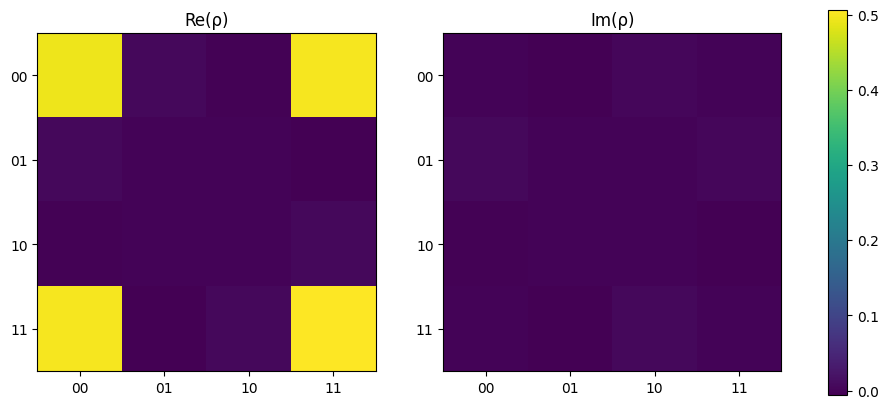

In [13]:
plot_density_matrix(rho)
plt.show()

After calculation, it is also possible to calculate the fidelity with respect to the expected matrix using the fidelity method. The tomography module contains a density_from_state function which enables the density matrix to be calculated from the expected state.

No imperfections were included within the system, so as expected the fidelity is 1.

In [14]:
rho_exp = density_from_state([2**-0.5, 0, 0, 2**-0.5])

print(f"Fidelity = {round(tomo.fidelity(rho_exp) * 100, 4)} %")

Fidelity = 100.0 %


### Imperfect SPS
It is also possible to include the error sources from the emulator to view how these change fidelity. Below, the SamplerExperiment is initalised to include a single photon source with indistinguishability of 95% and purity of 99%.

In [15]:
source = emulator.Source(indistinguishability=0.95, purity=0.99)

imperfect_exp = SamplerExperiment(2, source=source)

When re-running the state tomography, it can be seen how the denisty matrix begins to vary from ideal and the fidelity drops to ~96.2%.

Fidelity = 96.3872 %


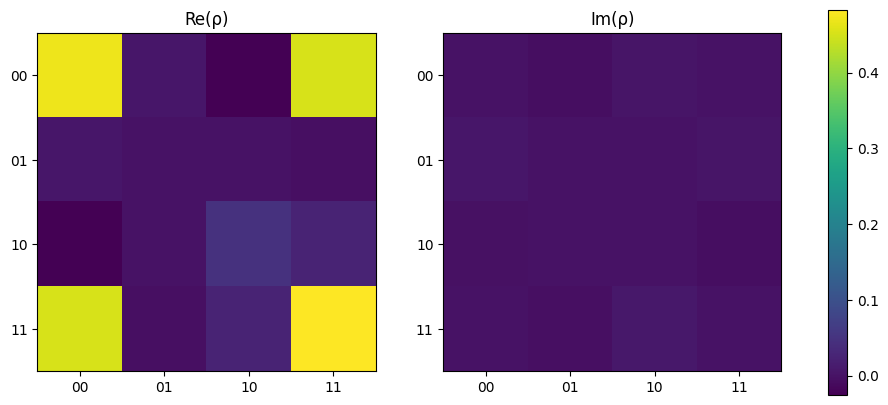

In [16]:
tomo = StateTomography(2, bell_circuit, imperfect_exp.experiment)

rho = tomo.process()

print(f"Fidelity = {round(tomo.fidelity(rho_exp) * 100, 4)} %")

plot_density_matrix(rho)
plt.show()